In [17]:

###FOREX DATA: https://ca.investing.com/currencies/cad-inr-historical-data

###INFLATION RATE (MONTHLY): https://www150.statcan.gc.ca/

###GDP(Quarterly): https://fred.stlouisfed.org/

###Employmentrate: https://www150.statcan.gc.ca/

###Interbankrate: https://fred.stlouisfed.org/

###shareprices: https://fred.stlouisfed.org/

In [18]:
## Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

# To Avoid Warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Importing the Data and Pre-processing 

In [19]:
## Import all feature .csv files

data_inr = pd.read_csv("./CAD_INR 2004-2021 Historical Data.csv") # CAD to Indian Rupees
data_usd = pd.read_csv("./CAD_USD 2004-2021 Historical Data.csv") # CAD to US Dollars
data_gbp = pd.read_csv("./CAD_GBP 2004-2021 Historical Data.csv") # CAD to British Pounds
data_jpy = pd.read_csv("./CAD_JPY 2004-2021 Historical Data.csv") # CAD to Japanese Yen
data_bhd = pd.read_csv("./CAD_BHD 2004-2021 Historical Data.csv") # CAD to Bahraini Dinar
data_gdp = pd.read_csv("./gdp_rate_2004_tilldate.csv") # Canada Gross Domestic Product - Quarterly
data_inflation = pd.read_csv("./CanadaInflation_2004_2021.csv") # Canada Inflation Rate % - Monthly
data_unemployment = pd.read_csv("./Unemploymentrate_2004_2021.csv") # Canada Employment Rate % - Monthly
data_interest = pd.read_csv("./InterbankRate_2004_tilldate.csv") # Canada Interbank Interest Rate % - Monthly
data_shareprices = pd.read_csv("./SharePrices_2004_tilldate.csv") # Canada SharePrices % - Quarterly


In [20]:
## Set Date Column as index for all

data_inr.Date = pd.to_datetime(data_inr.Date, dayfirst = True)
data_inr.set_index("Date", inplace=True)
data_usd.Date = pd.to_datetime(data_usd.Date, dayfirst = True)
data_usd.set_index("Date", inplace=True)
data_gbp.Date = pd.to_datetime(data_gbp.Date, dayfirst = True)
data_gbp.set_index("Date", inplace=True)
data_jpy.Date = pd.to_datetime(data_jpy.Date, dayfirst = True)
data_jpy.set_index("Date", inplace=True)
data_bhd.Date = pd.to_datetime(data_bhd.Date, dayfirst = True)
data_bhd.set_index("Date", inplace=True)

In [21]:
## GDP values, transform quarterly to daily, and impute using forward fill

data_gdp.Date = pd.to_datetime(data_gdp.Date, dayfirst = True)
data_gdp.rename({'DATE':'Date'},axis=1, inplace=True)
data_gdp.set_index("Date", inplace=True)

data_gdp = data_gdp.resample('B').sum().replace(0,np.nan)
data_gdp = data_gdp.fillna(method='ffill')

In [22]:
## Inflation values, transform monthly to daily, and impute using forward fill

data_inflation.year = pd.to_datetime(data_inflation.year, dayfirst = True)
data_inflation.rename({'year':'Date'},axis=1, inplace=True)
data_inflation.set_index("Date", inplace=True)

data_inflation = data_inflation.resample('B').sum().replace(0,np.nan)
data_inflation = data_inflation.fillna(method='ffill')

In [23]:
## Unemployment rate, transform monthly to daily, and impute using forward fill

data_unemployment.Date = pd.to_datetime(data_unemployment.Date, dayfirst = True)
data_unemployment.set_index("Date", inplace=True)

data_unemployment = data_unemployment.resample('B').sum().replace(0,np.nan)
data_unemployment = data_unemployment.fillna(method='ffill')

In [24]:
## Interest rate (Interbank) values, transform monthly to daily, and impute using forward fill

data_interest.Date = pd.to_datetime(data_interest.Date, dayfirst = True)
data_interest.set_index("Date", inplace=True)

data_interest = data_interest.resample('B').sum().replace(0,np.nan)
data_interest = data_interest.fillna(method='ffill')

In [25]:
## total Share price values, transform monthly to daily, and impute using forward fill

data_shareprices.Date = pd.to_datetime(data_shareprices.Date, dayfirst = True)
data_shareprices.set_index("Date", inplace=True)

data_shareprices = data_shareprices.resample('B').sum().replace(0,np.nan)
data_shareprices = data_shareprices.fillna(method='ffill')

In [26]:
## check if size is same for all features

print(data_inr.shape)
print(data_usd.shape)
print(data_gbp.shape)
print(data_jpy.shape)
print(data_bhd.shape)
print(data_gdp.shape)
print(data_inflation.shape)
print(data_unemployment.shape)
print(data_interest.shape)
print(data_shareprices.shape)

(4537, 5)
(4537, 5)
(4537, 5)
(4537, 5)
(4537, 5)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)


In [27]:
## Drop Unnecessary Columns for currencies

data_inr.drop(['Open','High','Low','Change %'],axis=1, inplace=True)
data_usd.drop(['Open','High','Low','Change %'],axis=1, inplace=True)
data_gbp.drop(['Open','High','Low','Change %'],axis=1, inplace=True)
data_jpy.drop(['Open','High','Low','Change %'],axis=1, inplace=True)
data_bhd.drop(['Open','High','Low','Change %'],axis=1, inplace=True)

In [28]:
## check if size is same for all features

print(data_inr.shape)
print(data_usd.shape)
print(data_gbp.shape)
print(data_jpy.shape)
print(data_bhd.shape)
print(data_gdp.shape)
print(data_inflation.shape)
print(data_unemployment.shape)
print(data_interest.shape)
print(data_shareprices.shape)

(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)
(4537, 1)


In [29]:
## Combine all currencies to 1 dataframe

data_currency = pd.concat([data_inr,data_usd,data_gbp,data_jpy,data_bhd],axis=1)

In [30]:
## Combine all data into 1 dataframe

df = pd.concat([data_currency,data_gdp,data_inflation,data_unemployment,data_interest,data_shareprices], axis=1)
df

,inr,usd,gbp,jpy,bhd,gdp_rate,inflation,unemployment_rate,interest_rate,share_priecs
Date,,,,,,,,,,
2004-01-01,35.171,0.7713,0.4329,82.91,0.2908,0.720268,0.013,7.3,2.508095,59.040291
2004-01-02,35.418,0.7757,0.4327,83.08,0.2926,0.720268,0.013,7.3,2.508095,59.040291
2004-01-05,35.603,0.7803,0.4321,82.98,0.2944,0.720268,0.013,7.3,2.508095,59.040291
2004-01-06,35.471,0.7779,0.4269,82.60,0.2932,0.720268,0.013,7.3,2.508095,59.040291
2004-01-07,35.345,0.7755,0.4265,82.46,0.2926,0.720268,0.013,7.3,2.508095,59.040291
...,...,...,...,...,...,...,...,...,...,...
2021-05-17,60.754,0.8285,0.5860,90.46,0.3117,1.600000,0.034,8.1,0.183075,133.626061
2021-05-18,60.537,0.8287,0.5840,90.23,0.3118,1.600000,0.034,8.1,0.183075,133.626061
2021-05-19,60.330,0.8241,0.5837,90.00,0.3106,1.600000,0.034,8.1,0.183075,133.626061


In [31]:
df = df.reset_index()

In [32]:
df.to_csv('data_combined_2021.csv', index=False)

In [33]:
df.isnull().sum()

Date                 0
inr                  0
usd                  0
gbp                  0
jpy                  0
bhd                  0
gdp_rate             0
inflation            0
unemployment_rate    0
interest_rate        0
share_priecs         0
dtype: int64

In [38]:
df.set_index('Date', inplace=True)

In [54]:
## EDA - Plot our variables one-by one

# Code modified from code written by Matthew Garton - from lecture.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(12,4))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=18)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=12);

In [44]:
df['gdp_rate']

Date
2004-01-01    0.720268
2004-01-02    0.720268
2004-01-05    0.720268
2004-01-06    0.720268
2004-01-07    0.720268
                ...   
2021-05-17    1.600000
2021-05-18    1.600000
2021-05-19    1.600000
2021-05-20    1.600000
2021-05-21    1.600000
Name: gdp_rate, Length: 4537, dtype: float64

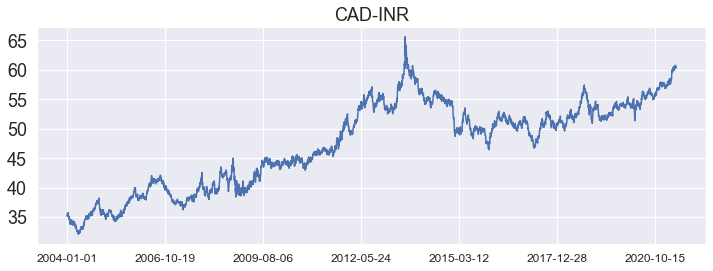

In [55]:
plot_series(df, ['inr'], title='CAD-INR', steps=730)

In [62]:
df[['inr']['2004-01-01']

SyntaxError: unexpected EOF while parsing (<ipython-input-62-b30e8344cfa0>, line 1)

In [ ]:
plt.figure(figsize=(10,5))

#plt.plot(data_inr.index,data_inr)
plt.plot(data_usd.index,data_usd, label='USD')
plt.plot(data_gbp.index,data_gbp, label ='GBP')
#plt.plot(data_jpy.index,data_jpy)
plt.plot(data_bhd.index,data_bhd, label = 'BHD')
plt.legend()
plt.title('CAD Exchange Rates comapared to other Countries', fontsize=20)

In [ ]:
import scipy.stats
import pylab

In [ ]:
plt.figure(figsize=(10,5))
scipy.stats.probplot(df['inr'], plot=pylab)
plt.title('CAD to INR distribution compared to Normal distribution', fontsize=20)
pylab.show()